In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import parmed as pmd
from paprika.analysis import fe_calc
from paprika.io import NumpyEncoder, load_restraints
from paprika.restraints.utils import extract_guest_restraints

### Initialize

In [2]:
base_name = "CB7-AMT-sol"
guest_resname = "AMT"
structure = pmd.load_file(
    f"{tmp_folder}/vac-dum.prmtop", f"{tmp_folder}/vac-dum.pdb", structure=True
)
restraints = load_restraints(filepath="restraints.json")
guest_restraints = extract_guest_restraints(structure, restraints, guest_resname)

### Calculate free enegy

In [3]:
free_energy = fe_calc()
free_energy.temperature = 298.15
free_energy.prmtop = "restrained.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = "simulations"
free_energy.restraint_list = restraints
free_energy.collect_data()
free_energy.methods = ["ti-block"]
free_energy.ti_matrix = "diagonal"
free_energy.compute_roi = True
free_energy.bootcycles = 2000
free_energy.compute_free_energy()
free_energy.compute_ref_state_work(guest_restraints)

### Save results

In [4]:
with open("binding_results.json", "w") as f:
    dumped = json.dumps(free_energy.results, cls=NumpyEncoder)
    f.write(dumped)

### Binding free-energy

In [5]:
fe_a = free_energy.results["attach"]["ti-block"]["fe"]
sem_a = free_energy.results["attach"]["ti-block"]["sem"]
roi_a = free_energy.results["attach"]["ti-block"]["roi"]
fe_p = free_energy.results["pull"]["ti-block"]["fe"]
sem_p = free_energy.results["pull"]["ti-block"]["sem"]
roi_p = free_energy.results["pull"]["ti-block"]["roi"]
fe_r = free_energy.results["release"]["ti-block"]["fe"]
sem_r = free_energy.results["release"]["ti-block"]["sem"]
roi_r = free_energy.results["release"]["ti-block"]["roi"]
fe_ref = free_energy.results["ref_state_work"]

binding = -1 * (
    free_energy.results["attach"]["ti-block"]["fe"]
    + free_energy.results["pull"]["ti-block"]["fe"]
    - free_energy.results["release"]["ti-block"]["fe"]
    + free_energy.results["ref_state_work"]
)

sem = np.sqrt(
    free_energy.results["attach"]["ti-block"]["sem"] ** 2
    + free_energy.results["pull"]["ti-block"]["sem"] ** 2
    + free_energy.results["release"]["ti-block"]["sem"] ** 2
)

In [6]:
print(f"Attach free-energy  = {fe_a:0.2f} +/- {sem_a:0.2f} kcal/mol")
print(f"Pull free-energy    = {fe_p:0.2f} +/- {sem_p:0.2f} kcal/mol")
print(f"Release free-energy = {fe_r:0.2f} +/- {sem_r:0.2f} kcal/mol")
print(f"Ref state-work      = {fe_ref:0.2f}")
print("-" * 30)
print(f"Binding free-energy = {binding:0.2f} +/- {sem:0.2f} kcal/mol")

Attach free-energy  = 952.61 +/- 0.10 kcal/mol
Pull free-energy    = 12.94 +/- 0.33 kcal/mol
Release free-energy = 935.29 +/- 0.06 kcal/mol
Ref state-work      = -7.14
Binding free-energy = -23.12 +/- 0.35 kcal/mol


### Free-energy plots

Text(0.5, 1.0, 'Release phase')

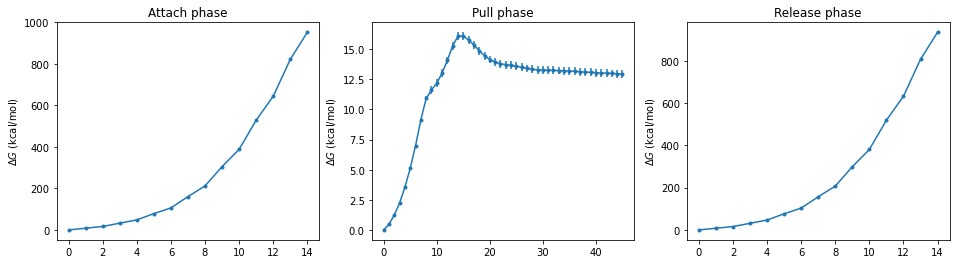

In [7]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.errorbar(
    range(len(free_energy.results["attach"]["ti-block"]["fe_matrix"][0, :])),
    free_energy.results["attach"]["ti-block"]["fe_matrix"][0, :],
    yerr=free_energy.results["attach"]["ti-block"]["sem_matrix"][0, :],
    fmt=".-",
)
plt.ylabel(r"$\Delta G$ (kcal/mol)")
plt.title("Attach phase")

plt.subplot(1, 3, 2)
plt.errorbar(
    range(len(free_energy.results["pull"]["ti-block"]["fe_matrix"][0, :])),
    free_energy.results["pull"]["ti-block"]["fe_matrix"][0, :],
    yerr=free_energy.results["pull"]["ti-block"]["sem_matrix"][0, :],
    fmt=".-",
)
plt.ylabel(r"$\Delta G$ (kcal/mol)")
plt.title("Pull phase")

plt.subplot(1, 3, 3)
plt.errorbar(
    range(len(free_energy.results["release"]["ti-block"]["fe_matrix"][0, :])),
    free_energy.results["release"]["ti-block"]["fe_matrix"][0, :],
    yerr=free_energy.results["release"]["ti-block"]["sem_matrix"][0, :],
    fmt=".-",
)
plt.ylabel(r"$\Delta G$ (kcal/mol)")
plt.title("Release phase")